# Using Matching to Adjust for non-ECOA-protected variables

In this notebook, we use matching to reduce the original Adult dataset down to a subset where both White adults and non-White adults in the data has similar controls. 

To do this, we use the DAME-FLAME algorithm that matches all the observations in each protected group (race and sex) by the covariates (the non-protected variables such as income). The dataset that we are dealing is particular in that it has income as the outcome variable, this means that we will use demographic variables about individual adults to predict whether an individual's income is above or below $50k.

In a previous analysis, we found that there was significant bias in the training data, with 

In [61]:
from aif360.datasets import AdultDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


### Data Cleaning

Before we feed the data into the DAME algorithm, we need to clean it because DAME only takes in categorical inputs. Additionally, we want to check if there are significant differences in numeric variables to justify us keeping them in the matching process.

In [2]:
adult = AdultDataset()

In [6]:
adult_df = adult.convert_to_dataframe()[0]
adult_df.columns

Index(['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov',
       'workclass=Private', 'workclass=Self-emp-inc',
       'workclass=Self-emp-not-inc', 'workclass=State-gov',
       'workclass=Without-pay', 'education=10th', 'education=11th',
       'education=12th', 'education=1st-4th', 'education=5th-6th',
       'education=7th-8th', 'education=9th', 'education=Assoc-acdm',
       'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate',
       'education=HS-grad', 'education=Masters', 'education=Preschool',
       'education=Prof-school', 'education=Some-college',
       'marital-status=Divorced', 'marital-status=Married-AF-spouse',
       'marital-status=Married-civ-spouse',
       'marital-status=Married-spouse-absent', 'marital-status=Never-married',
       'marital-status=Separated', 'marital-status=Widowed',
       'occupation=Adm-clerical', 'occupation=Armed-Forces',
       'oc

In [8]:
adult_df.value_counts("race")

race
1.0    38903
0.0     6319
Name: count, dtype: int64

Text(0.5, 1.0, 'White and Non-White adults share similar work hours')

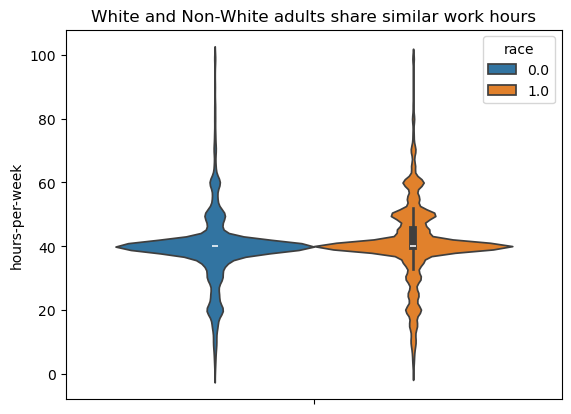

In [13]:
sns.violinplot(y = "hours-per-week", hue = 'race', data = adult_df)
plt.title("White and Non-White adults share similar work hours")

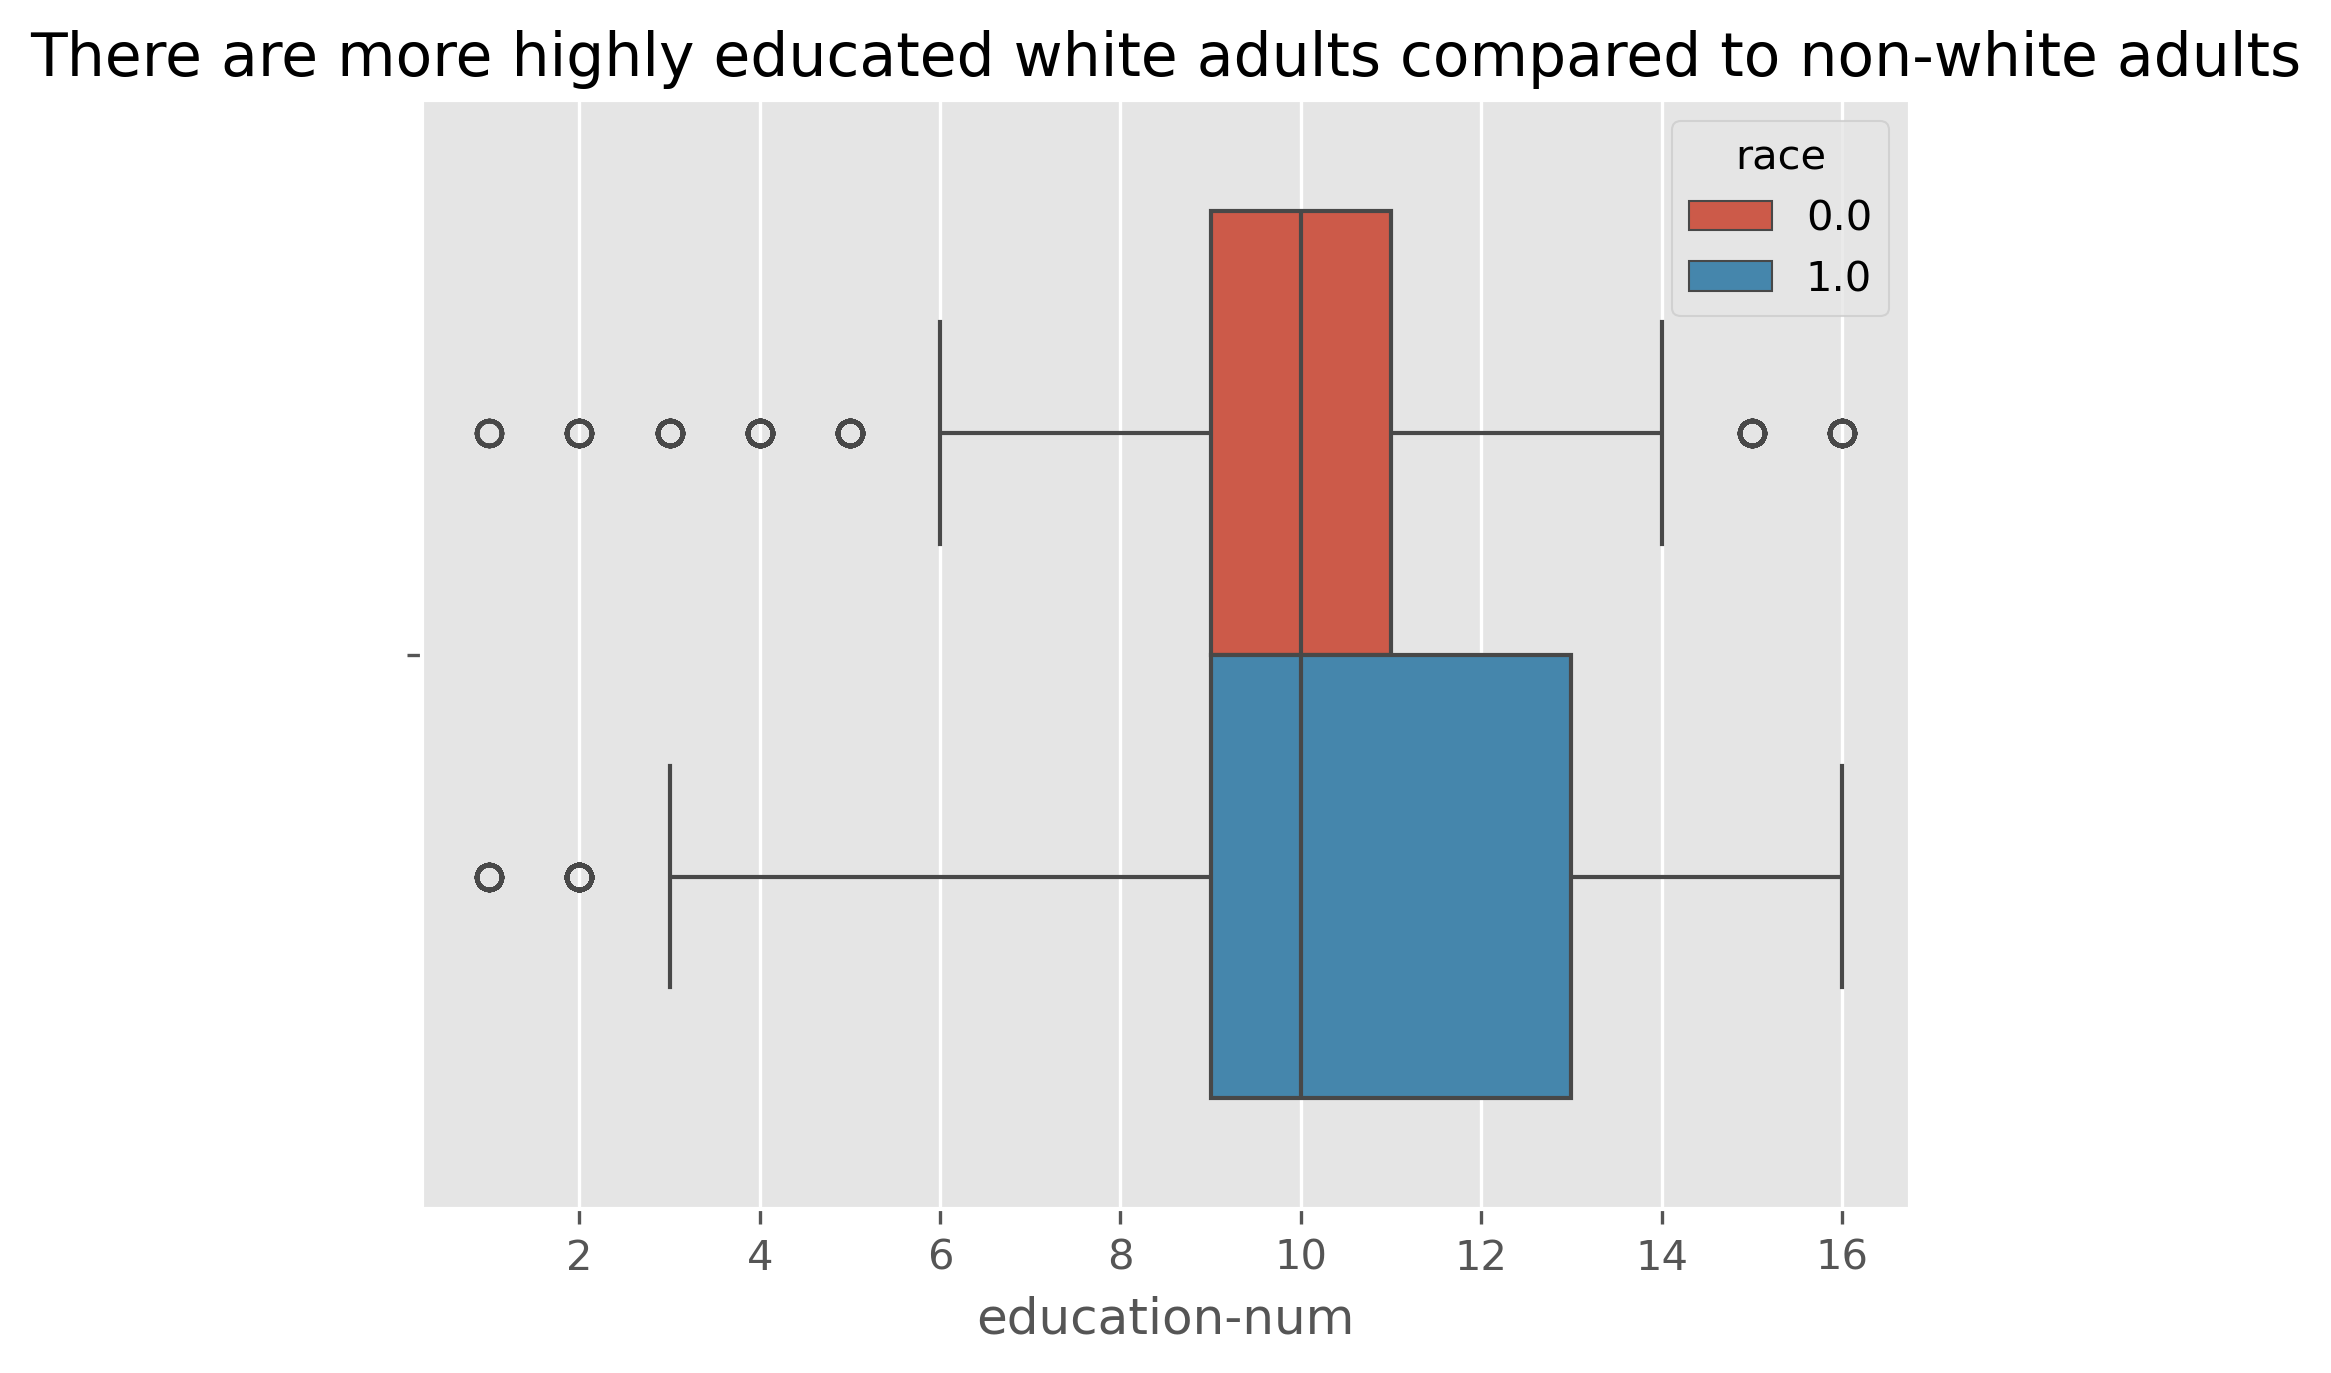

In [115]:
sns.boxplot(x = "education-num", hue = 'race', data = adult_df)
plt.title("White Adults in the Dataset are more likely to be ")
plt.show()

### Check for balance

In [22]:
## difference in education
from scipy.stats import ttest_ind

difference_edu = (
    adult_df.loc[adult_df['race'] == 0, 'education-num'].mean() -
    adult_df.loc[adult_df['race'] == 1, 'education-num'].mean()
)

t_stat, p_value = ttest_ind(
    adult_df.loc[adult_df['race'] == 0, 'education-num'],
    adult_df.loc[adult_df['race'] == 1, 'education-num'],
    nan_policy="omit",
)

print(f"Non-White people have {difference_edu:.2f} years of education less on average compared to White people in the data.")

print(
    f"The t-test has a t-statistic of {t_stat:.2f}," 
    f" and a p-value of {p_value:.2f}."
)

Non-White people have -0.38 years of education less on average compared to White people in the data.
The t-test has a t-statistic of -10.98, and a p-value of 0.00.


In [29]:
## difference in hours worked per week
from scipy.stats import ttest_ind

difference_hours = (
    adult_df.loc[adult_df['race'] == 0, 'hours-per-week'].mean() -
    adult_df.loc[adult_df['race'] == 1, 'hours-per-week'].mean()
)

t_stat, p_value = ttest_ind(
    adult_df.loc[adult_df['race'] == 0, 'hours-per-week'],
    adult_df.loc[adult_df['race'] == 1, 'hours-per-week'],
    nan_policy="omit",
)

print(f"Non-White people work {difference_edu:.2f} hours less on average compared to White people in the data.")

print(
    f"The t-test has a t-statistic of {t_stat:.2f}," 
    f" and a p-value of {p_value:.2f}."
)

Non-White people work -0.38 hours less on average compared to White people in the data.
The t-test has a t-statistic of -11.13, and a p-value of 0.00.


### Discritize Age and Hours Worked Variable

<Axes: xlabel='hours-per-week', ylabel='Count'>

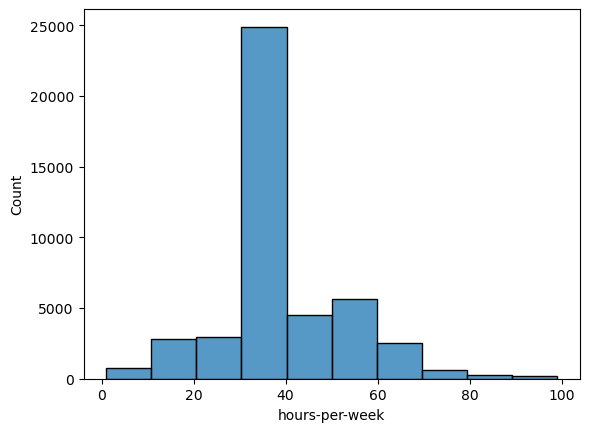

In [24]:
sns.histplot(data = adult_df, x = "hours-per-week", bins = 10)

In [42]:
bins = [18, 30, 40, 50, 60, 100]
labels = ["18-29", "30-39", "40-49", "50-59", "60-99"]
adult_df["age_discreet"] = pd.cut(adult_df["age"], bins=bins, labels=labels, right=False)
adult_df["age_discreet"] = pd.Categorical(adult_df["age_discreet"]).codes
bins_hours = [0,10,20,30,40,50,60,70,80,90,100]
labels_hours = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-99"]
adult_df["hours_discreet"] = pd.cut(adult_df["hours-per-week"], bins=bins_hours, labels=labels_hours, right=False)
adult_df["hours_discreet"] = pd.Categorical(adult_df["hours_discreet"]).codes

### Drop numerical variables

In [43]:
# Make clean copy of the adult dataset
adult_clean = adult_df.copy()
# Drop the numerical variables
adult_clean = adult_clean.drop(columns = ['education-num', 'age', 'capital-gain', 'capital-loss', 'hours-per-week'])

### Apply DAME algorithm

In [44]:
adult_clean.dtypes

race                         float64
sex                          float64
workclass=Federal-gov        float64
workclass=Local-gov          float64
workclass=Private            float64
                              ...   
native-country=Vietnam       float64
native-country=Yugoslavia    float64
income-per-year              float64
age_discreet                    int8
hours_discreet                  int8
Length: 96, dtype: object

In [46]:
import dame_flame

model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True, early_stop_iterations=50)
model.fit(
    adult_clean,
    treatment_column_name="race",
    outcome_column_name="income-per-year",
)
result = model.predict(adult_clean)

Completed iteration 0 of matching
	Number of matched groups formed in total:  2100
	Unmatched treated units:  14442 out of a total of  38903 treated units
	Unmatched control units:  1684 out of a total of  6319 control units
	Number of matches made this iteration:  29096
	Number of matches made so far:  29096
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.2163222778116225
Completed iteration 1 of matching
	Number of matched groups formed in total:  2562
	Unmatched treated units:  11192 out of a total of  38903 treated units
	Unmatched control units:  987 out of a total of  6319 control units
	Number of matches made this iteration:  3947
	Number of matches made so far:  33043
	Covariates dropped so far:  frozenset({'workclass=State-gov'})
	Predictive error of covariate set used to match:  0.21632227216850786
Completed iteration 2 of matching
	Number of matched groups formed in total:  2638
	Unmatched treated units:  11055 out of a total of  38903

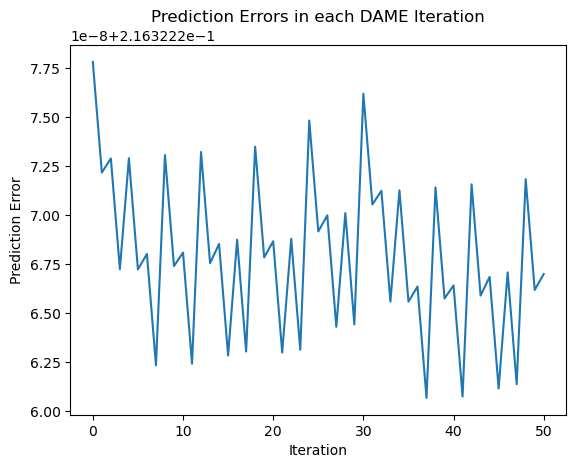

In [50]:
pe = model.pe_each_iter
plt.plot(pe)
plt.xlabel("Iteration")
# plt.xticks(ticks=range(0, 50), labels=range(1, 51))
plt.ylabel("Prediction Error")
plt.title("Prediction Errors in each DAME Iteration")
plt.show()

In [56]:
model = dame_flame.matching.DAME(
    repeats=False, verbose=3, want_pe=True, early_stop_iterations=37
)
model.fit(
    adult_clean,
    treatment_column_name="race",
    outcome_column_name="income-per-year",
)
result = model.predict(adult_clean)

Completed iteration 0 of matching
	Number of matched groups formed in total:  2100
	Unmatched treated units:  14442 out of a total of  38903 treated units
	Unmatched control units:  1684 out of a total of  6319 control units
	Number of matches made this iteration:  29096
	Number of matches made so far:  29096
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.2163222778116225
Completed iteration 1 of matching
	Number of matched groups formed in total:  2562
	Unmatched treated units:  11192 out of a total of  38903 treated units
	Unmatched control units:  987 out of a total of  6319 control units
	Number of matches made this iteration:  3947
	Number of matches made so far:  33043
	Covariates dropped so far:  frozenset({'workclass=State-gov'})
	Predictive error of covariate set used to match:  0.21632227216850786
Completed iteration 2 of matching
	Number of matched groups formed in total:  2638
	Unmatched treated units:  11055 out of a total of  38903

In [57]:
import numpy as np
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [58]:
matched_adult = get_dataframe(model, result)

/var/folders/0d/23x0hjl172sgh7hhvyngkf9m0000gn/T/ipykernel_19743/4264949956.py:18: FutureWarning: The provided callable <function sum at 0x10652a660> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)


### Re-calculate the fairness metrics for the matched dataset

In [60]:
### Instantiate the PDKK dataset as a BinaryLabelDataset

# Protected attributes
protected_attributes = ['race', 'sex']
# Priviledged classes
privileged_classes = [[1, 1]]
# Favorble Target label
favorable_target_label = [1]
# Create the binary label dataset object
adult_standard = StandardDataset(
    df = matched_adult,
    label_name = "income-per-year",
    favorable_classes = favorable_target_label,
    protected_attribute_names = protected_attributes,
    privileged_classes = privileged_classes
)

In [62]:
### Get disparate impact on the intersection of race and sex
adult_fairness_metric = BinaryLabelDatasetMetric(
    adult_standard,
    unprivileged_groups=[{"race":0, "sex":0}],
    privileged_groups=[{"race":1, "sex":1}]
)
print(
    "Disparate Impact based on intersection of race and sex: " +
    f"{adult_fairness_metric.disparate_impact():.3f}.")

### Get disparate impact based on race only
adult_fairness_metric = BinaryLabelDatasetMetric(
    adult_standard,
    unprivileged_groups=[{"race":0}],
    privileged_groups=[{"race":1}]
)
print(
    "Disparate Impact based on race alone: " +
    f"{adult_fairness_metric.disparate_impact():.3f}.")

### Get disparate impact based on sex only
adult_fairness_metric = BinaryLabelDatasetMetric(
    adult_standard,
    unprivileged_groups=[{"sex":0}],
    privileged_groups=[{"sex":1}]
)
print(
    "Disparate Impact based on sex alone: " +
    f"{adult_fairness_metric.disparate_impact():.3f}.")

Disparate Impact based on intersection of race and sex: 0.220.
Disparate Impact based on race alone: 0.620.
Disparate Impact based on sex alone: 0.288.


Before matching:
Disparate Impact on Intersection of Race and Sex: 0.235
Disparate Impact on Race Alone: 0.604
Disparate Impact on Sex Alone: 0.363

### Concept Visualization

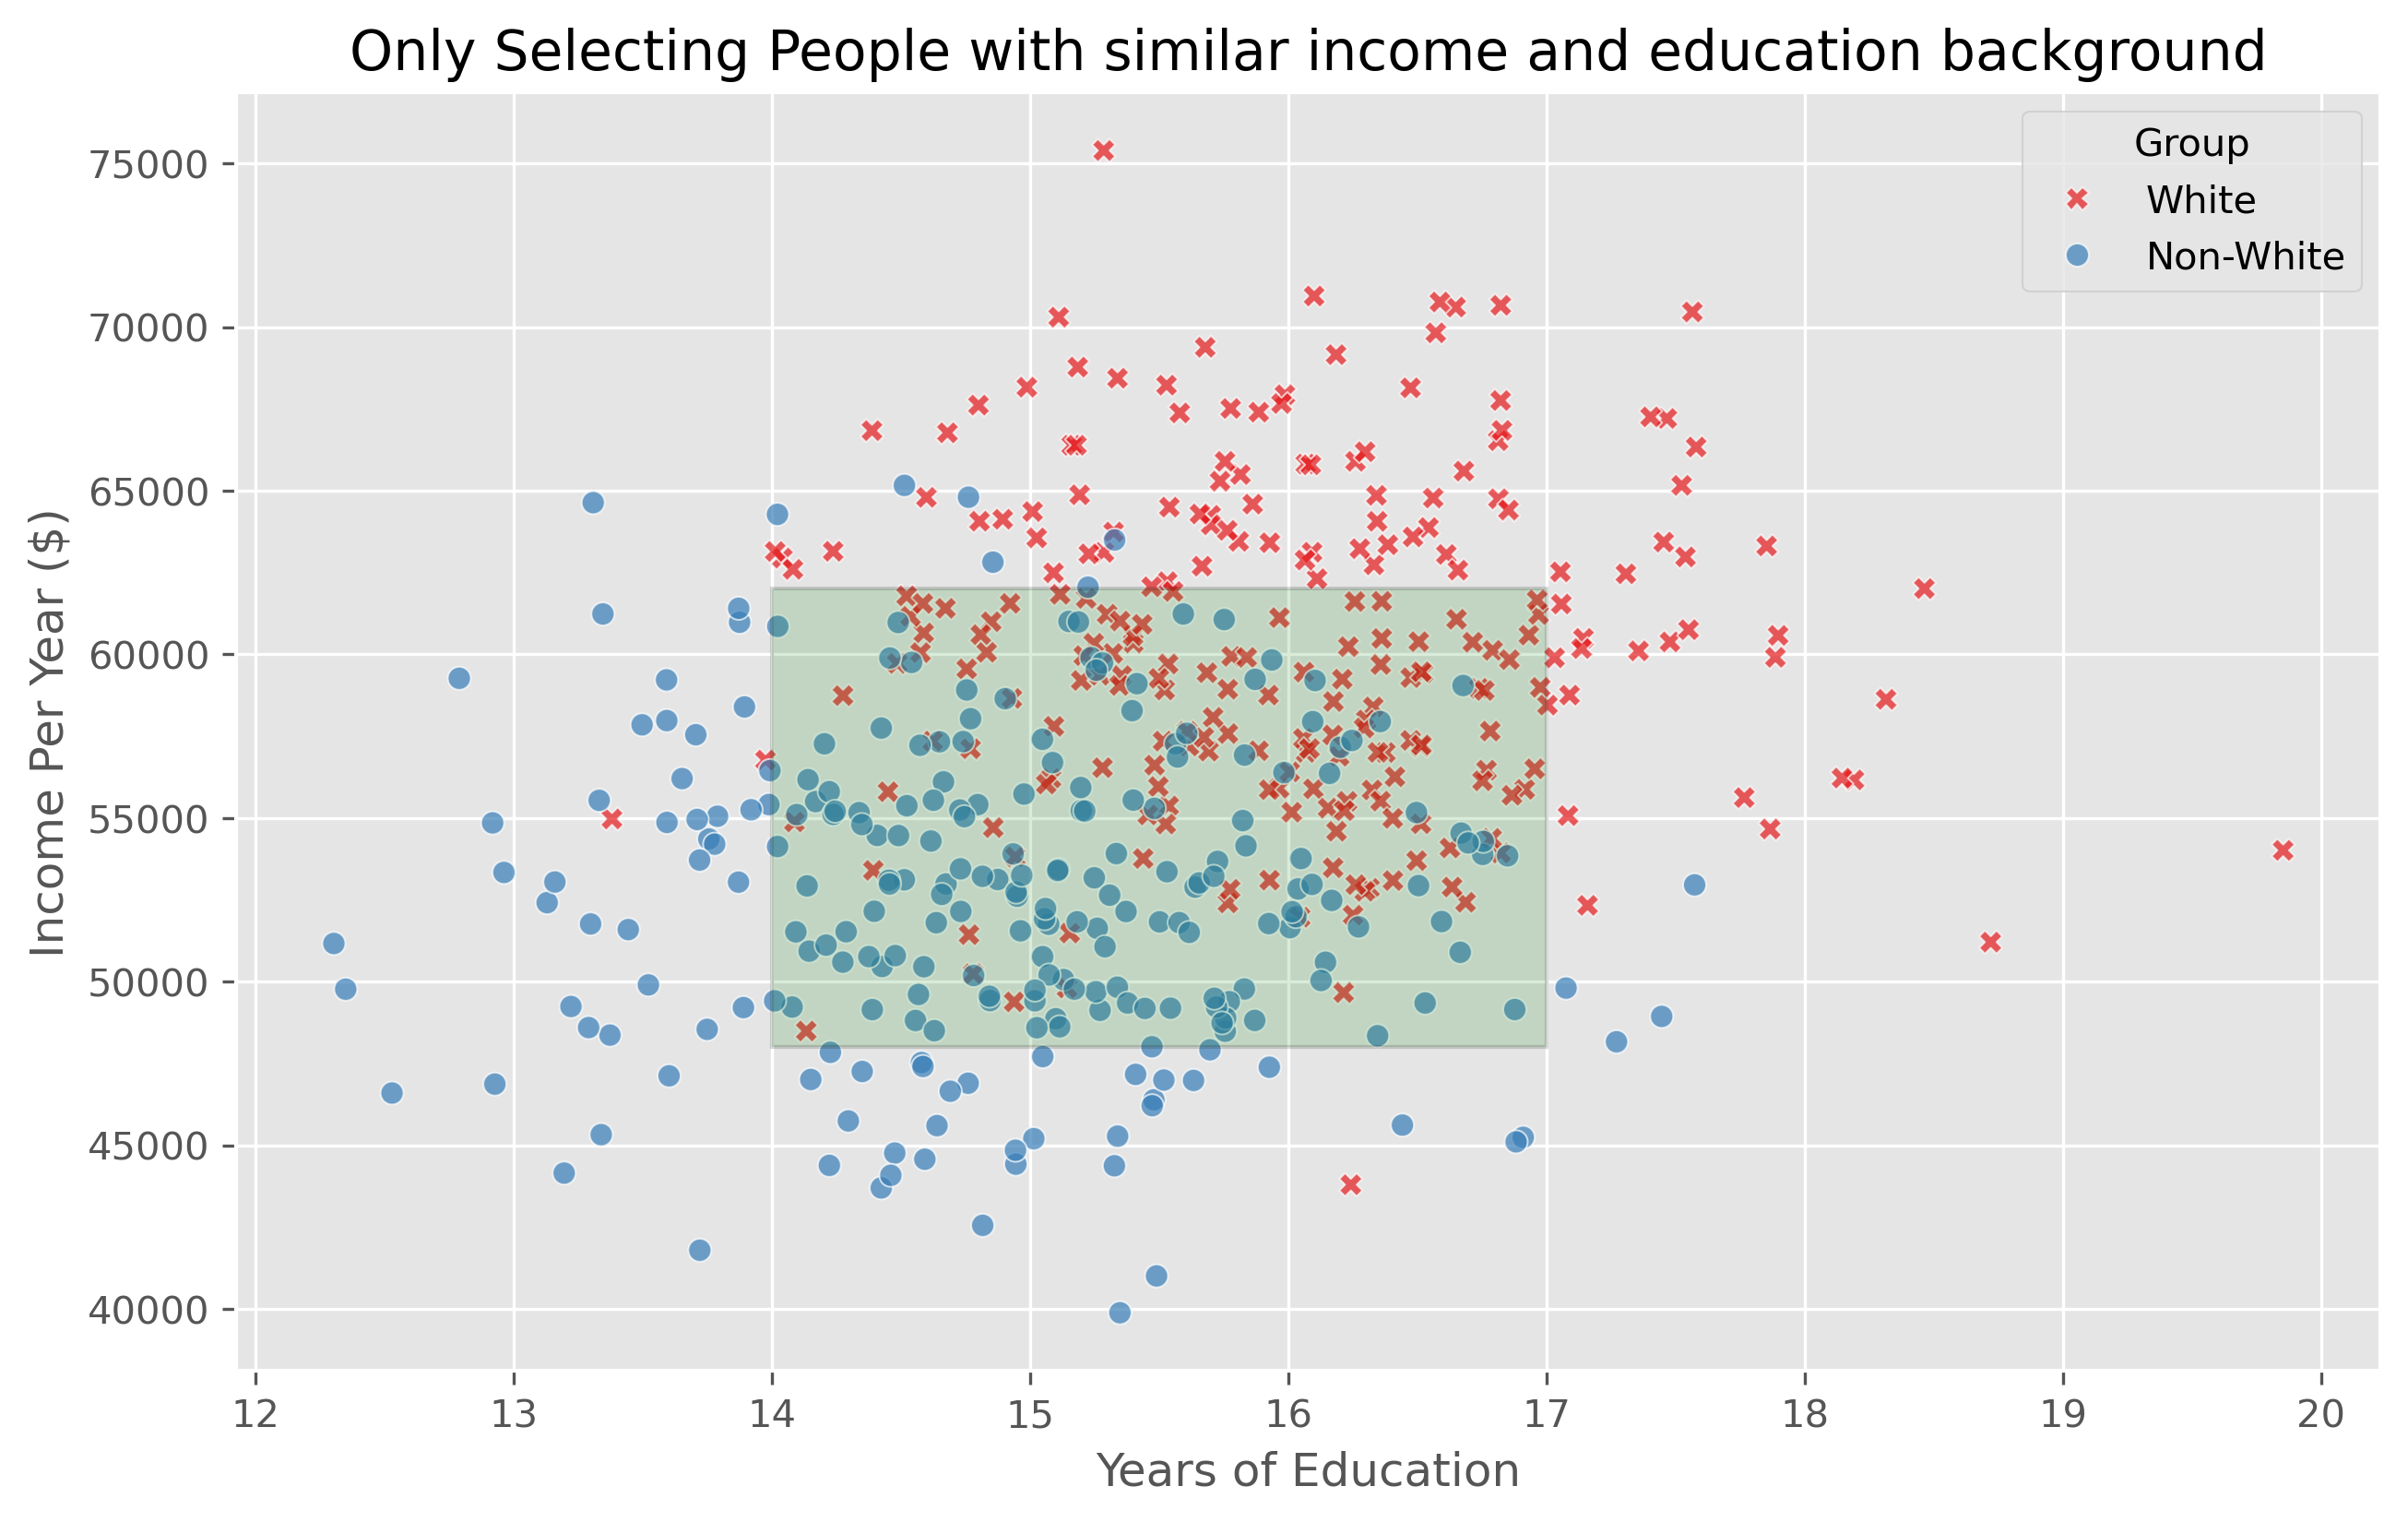

In [110]:
# Adjusting the data generation to have different distributions with lower variance and different support
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.style.use('ggplot')
np.random.seed(42)  # For reproducibility

# Adjusted parameters for lower variance and different means
groupA = 250
groupB = 250
groupA_data = pd.DataFrame({
    'education': np.random.normal(loc=16, scale=1, size=groupA),  # Higher average education
    'income': np.random.normal(loc=60000, scale=5000, size=groupA),  # Higher average income
    'group': 'White'
})
groupB_data = pd.DataFrame({
    'education': np.random.normal(loc=15, scale=1, size=groupB),
    'income': np.random.normal(loc=52000, scale=5000, size=groupB),
    'group': 'Non-White'
})
data = pd.concat([groupA_data, groupB_data]).reset_index(drop=True)

# Visualization with adjustments for matched/unmatched visibility and distinct symbols
fig, ax = plt.subplots(figsize=(10, 6))
# Adjusting the alpha values for matched and unmatched to make matched darker and unmatched lighter
sns.scatterplot(data=data, x='education', y='income', hue='group', style='group', markers={'White': 'X', 'Non-White': 'o'}, alpha=0.7, palette='Set1', ax = ax)
rect = patches.Rectangle((14, 48000), 3, 14000, linewidth=1, edgecolor='black', facecolor='green', alpha = 0.15)
ax.add_patch(rect)
ax.set_title('Only Selecting People with similar income and education background')
ax.set_xlabel('Years of Education')
ax.set_ylabel('Income Per Year ($)')
plt.legend(title='Group')
plt.show()

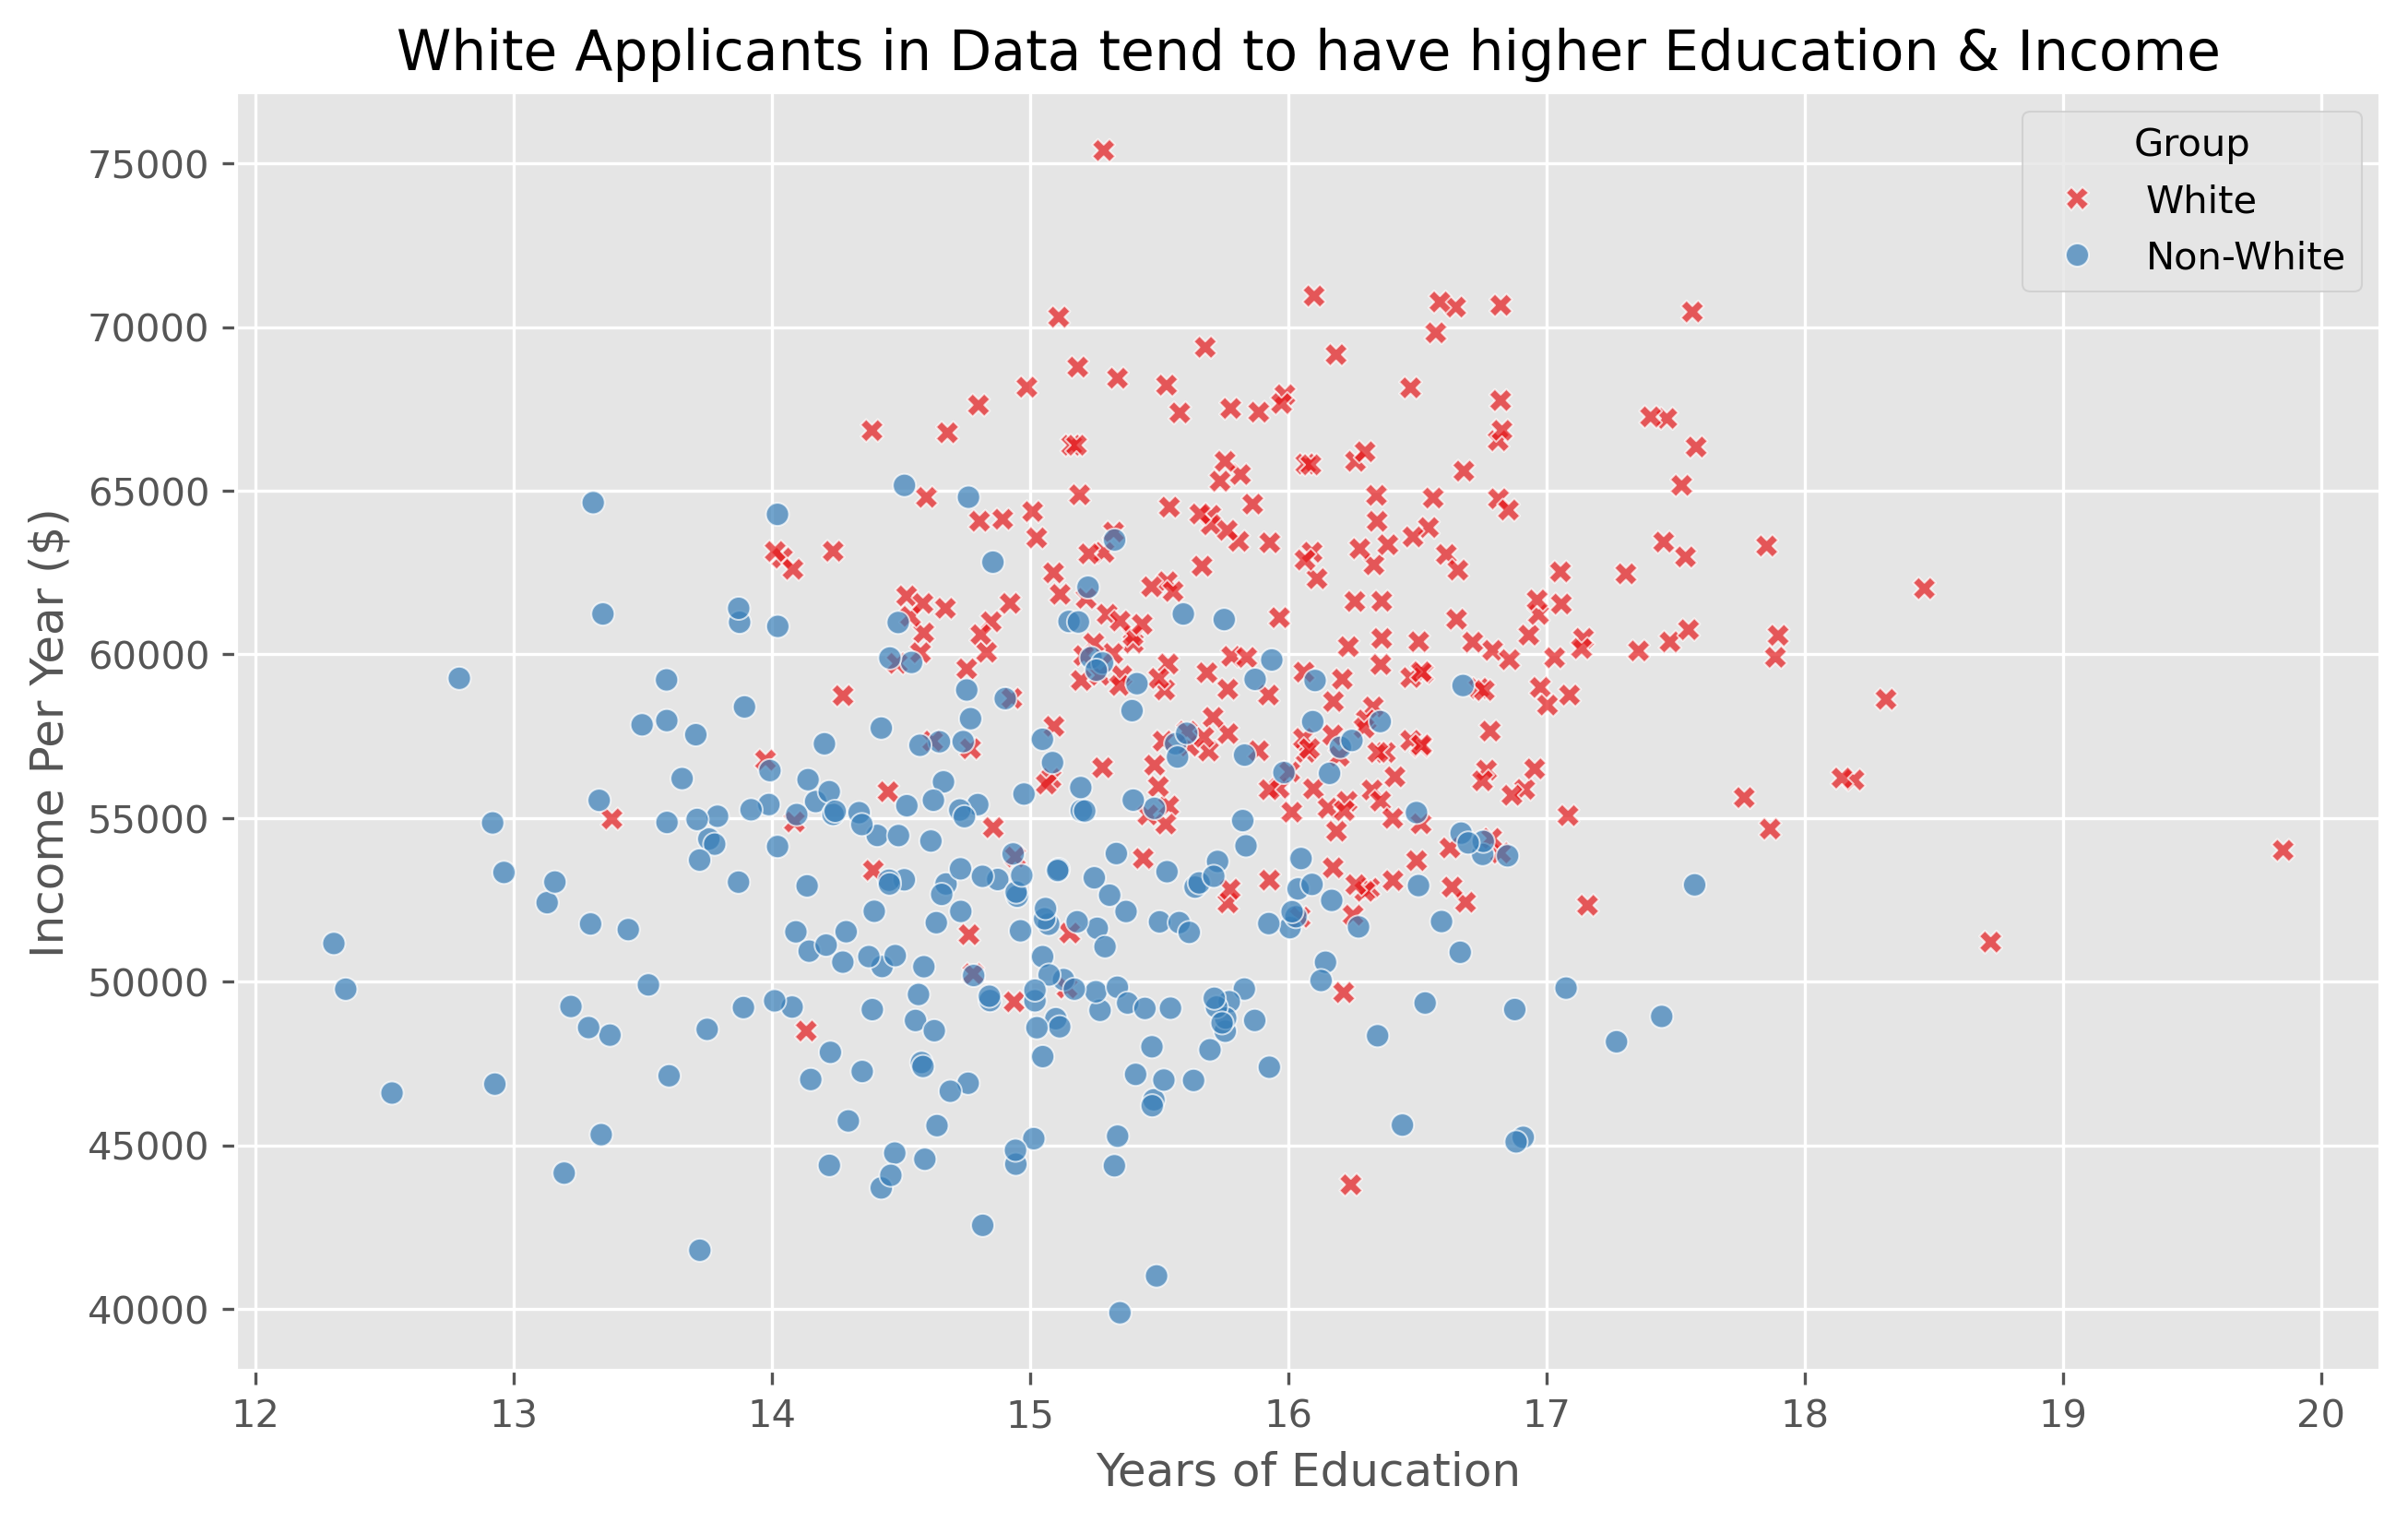

In [114]:
# Visualization with adjustments for matched/unmatched visibility and distinct symbols
fig, ax = plt.subplots(figsize=(10, 6))
# Adjusting the alpha values for matched and unmatched to make matched darker and unmatched lighter
sns.scatterplot(data=data, x='education', y='income', hue='group', style='group', markers={'White': 'X', 'Non-White': 'o'}, alpha=0.7, palette='Set1', ax = ax)
rect = patches.Rectangle((14, 48000), 3, 14000, linewidth=1, edgecolor='black', facecolor='green', alpha = 0.15)
# ax.add_patch(rect)
ax.set_title('White Applicants in Data tend to have higher Education & Income')
ax.set_xlabel('Years of Education')
ax.set_ylabel('Income Per Year ($)')
plt.legend(title='Group')
plt.show()

<BarContainer object of 2 artists>

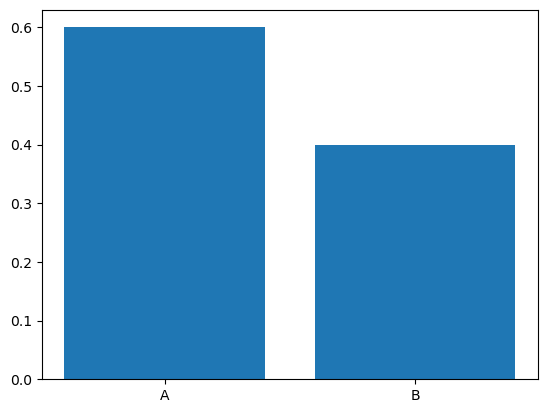

In [106]:
plt.bar(x = ["A", "B"], height = [0.6,0.4])

<BarContainer object of 2 artists>

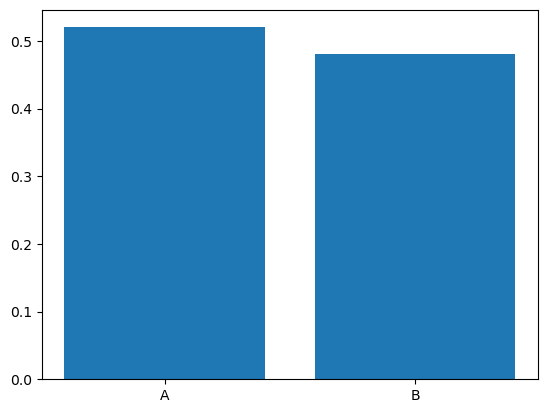

In [107]:
plt.bar(x = ["A", "B"], height = [0.52,0.48])